![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/legal-nlp/08.1.Automatic_Question_Generation_Legal_Texts.ipynb)

# Answering Questions on Legal Texts
One of the latests biggest outcomes in NLP are **Language Models** and their ability to answer questions, expressed in natural language.

> *In February 2017, the Company entered into an asset purchase agreement with NetSeer, Inc.
...
 The Company hereby grants to Seller a perpetual, non-exclusive, royalty-free license.
...
On March 12, 2020, we closed a Loan and Security Agreement with Hitachi Capital American Corp (also known as "Hitachi")
...*




```
- What is the type of agreement?
- What is the type of license?
- What are the companies in the agreement?
- What is also known as the different compaines?
- Who is the recipient of a license?
````

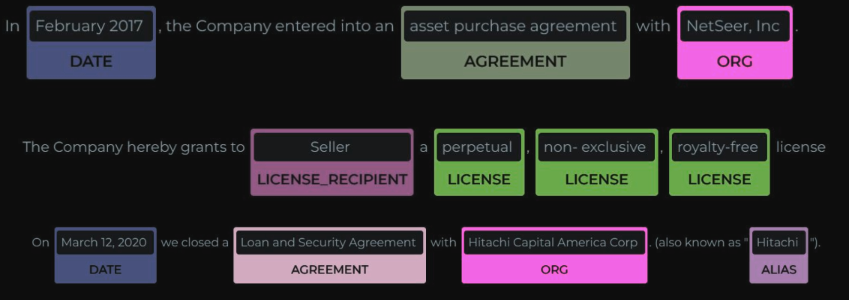



**Question Answeering (QA)** uses specific Language Models trained to carry out **Natural Language Inference (NLI)**

**NLI** works as follows:
- Given a text as a Premise (P);
- Given a hypotheses (H) as a question to be solved;
   - Then, we ask the Language Model is H is `entailed`, `contradicted` or `not related` in P. 


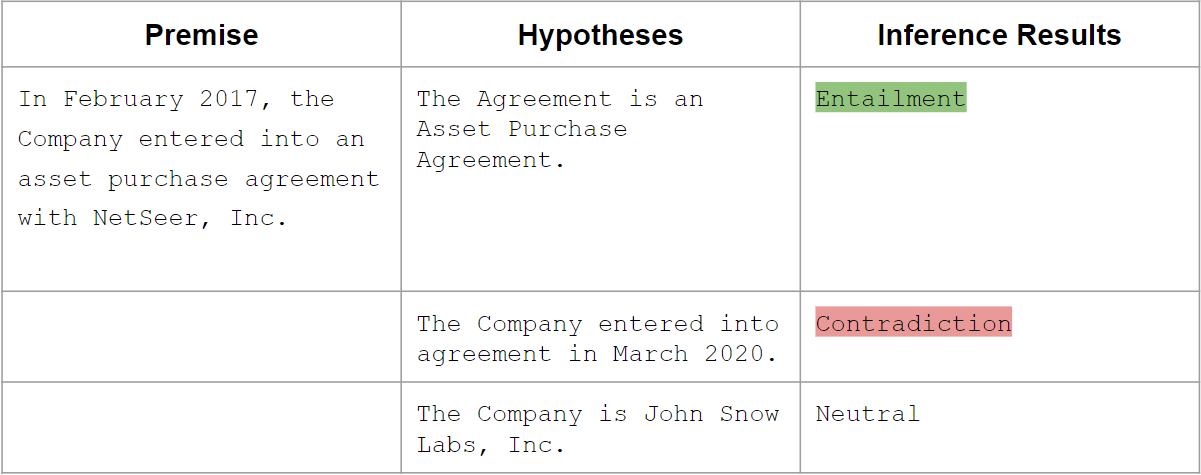

Although we are not getting into the maths of it, it's basically done by using a Language Model to encode P, H and then carry out sentence similarity operations.

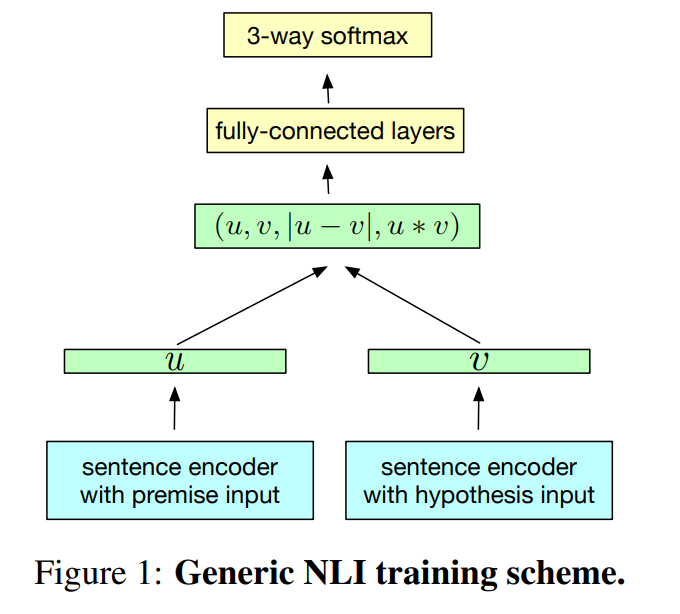

# Creating questions on the fly: NerQuestionGenerator
Legal documents are known to be very long. Although you can divide the documents into paragraphs or sections, and those into sentences, the resulted sentences are still long.

Let's take a look at this example:

> `Buyer shall use such materials and supplies only in accordance with the present agreement`

Let's target the extraction of the OBJECT (`such materials...`)

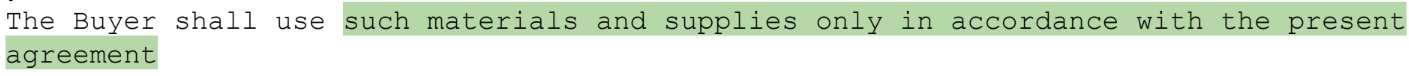

To do that, we can divide these kind of sentences into 3 parts:
1. The Subject (`Buyer`)
2. The Action (`shall use`)
3. The Object (what the Buyer shall use? - `such materials and supplies only in accordance with the present agreement`)

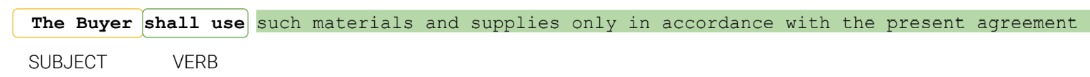

These are the steps we are going to follow:

1. We use NER to detect easy entities as the `Subject` and the `Action`. 
   - Example: `Buyer - SUBJECT`, `shall use - ACTION`

2. Automatically generate a question to ask for the `Object`, using `Subject` and `Action`;
   - Example: `What shall the Buyer use?`

3. Use the question and the sentence to retrieve `Object`
   - Example: `What shall the Buyer use? such materials and supplies only in accordance with the present agreement`

Last, but not least, it's very important to chose a domain-specific Question Answering model.


# Installation

In [ ]:
! pip install -q johnsnowlabs

## Automatic Installation
Using my.johnsnowlabs.com SSO

In [ ]:
from johnsnowlabs import nlp, legal

# nlp.install(force_browser=True)

## Manual downloading
If you are not registered in my.johnsnowlabs.com, you received a license via e-email or you are using Safari, you may need to do a manual update of the license.

- Go to my.johnsnowlabs.com
- Download your license
- Upload it using the following command

In [ ]:
from google.colab import files
print('Please Upload your John Snow Labs License using the button below')
license_keys = files.upload()

- Install it

In [ ]:
nlp.install()

# Starting

In [ ]:
spark = nlp.start()

Let's read and normalize a little the spacing of the NLP models may think those are different sentences and get unexpected results.

In [ ]:
text = """The Buyer shall use such materials and supplies only in accordance with the present agreement"""

#1. Extracting SUBJECT and VERB

## OPTION a: Use Dependency Parsing to retrieve SUBJECT and ACTION
Let's go the *grammatical* way!

Let's use `Part of Speech` and  `Dependency Parsing` to check for the SUBJECT and ACTION.

- `PoS` retrieves morphological information of the words, like `VERB`, `NOUN`, etc.
- `Dependency Parsing` categories chunks by their grammatical role: `SUBJECT` and connects chunks together using their dependencies.

For more information about `PoS` and `DepParsing`, please check the Spark NLP (Open Source) notebooks.

In [ ]:
import pandas as pd

documentAssembler = nlp.DocumentAssembler()\
  .setInputCol("text")\
  .setOutputCol("document")

tokenizer = nlp.Tokenizer()\
  .setInputCols("document")\
  .setOutputCol("token")

pos = nlp.PerceptronModel.pretrained("pos_anc", 'en')\
  .setInputCols("document", "token")\
  .setOutputCol("pos")

dep_parser = nlp.DependencyParserModel.pretrained('dependency_conllu')\
  .setInputCols(["document", "pos", "token"])\
  .setOutputCol("dependency")

typed_dep_parser = nlp.TypedDependencyParserModel.pretrained('dependency_typed_conllu')\
  .setInputCols(["token", "pos", "dependency"])\
  .setOutputCol("dependency_type")

nlpPipeline = nlp.Pipeline(
    stages=[
        documentAssembler, 
        tokenizer,
        pos,
        dep_parser,
        typed_dep_parser
        ])

pos_anc download started this may take some time.
Approximate size to download 3.9 MB
[OK!]
dependency_conllu download started this may take some time.
Approximate size to download 16.7 MB
[OK!]
dependency_typed_conllu download started this may take some time.
Approximate size to download 2.4 MB
[OK!]


In [ ]:
text_df = spark.createDataFrame([[text]]).toDF("text")

fit_model = nlpPipeline.fit(text_df)

result = fit_model.transform(text_df)

In [ ]:
from pyspark.sql import functions as F
result_df = result.select(F.explode(F.arrays_zip(result.token.result, 
                                                 result.token.begin, 
                                                 result.token.end, 
                                                 result.dependency.result, 
                                                 result.dependency_type.result,
                                                 result.pos.result)).alias("cols")) \
                  .select(F.expr("cols['0']").alias("chunk"),
                          F.expr("cols['1']").alias("begin"),
                          F.expr("cols['2']").alias("end"),
                          F.expr("cols['3']").alias("dependency"),
                          F.expr("cols['4']").alias("dependency_type"),
                          F.expr("cols['5']").alias("PoS")).toPandas()

In [ ]:
result_df

,chunk,begin,end,dependency,dependency_type,PoS
0,The,0,2,Buyer,nsubj,DT
1,Buyer,4,8,use,nsubj,NNP
2,shall,10,14,use,appos,MD
3,use,16,18,ROOT,root,VB
4,such,20,23,materials,amod,JJ
5,materials,25,33,use,nsubj,NNS
6,and,35,37,supplies,cc,CC
7,supplies,39,46,materials,nsubj,NNS
8,only,48,51,accordance,amod,RB
9,in,53,54,accordance,det,IN


### Let's visualize with Spark NLP Display
To do that, we need the results of a LightPipeline

In [ ]:
lp = nlp.LightPipeline(fit_model)
pipeline_result = lp.fullAnnotate(text)

In [ ]:
from sparknlp_display import DependencyParserVisualizer

dependency_vis = DependencyParserVisualizer()

dependency_vis.display(pipeline_result[0], #should be the results of a single example, not the complete dataframe.
                       pos_col = 'pos', #specify the pos column
                       dependency_col = 'dependency', #specify the dependency column,
                       dependency_type_col = 'dependency_type'
                       )

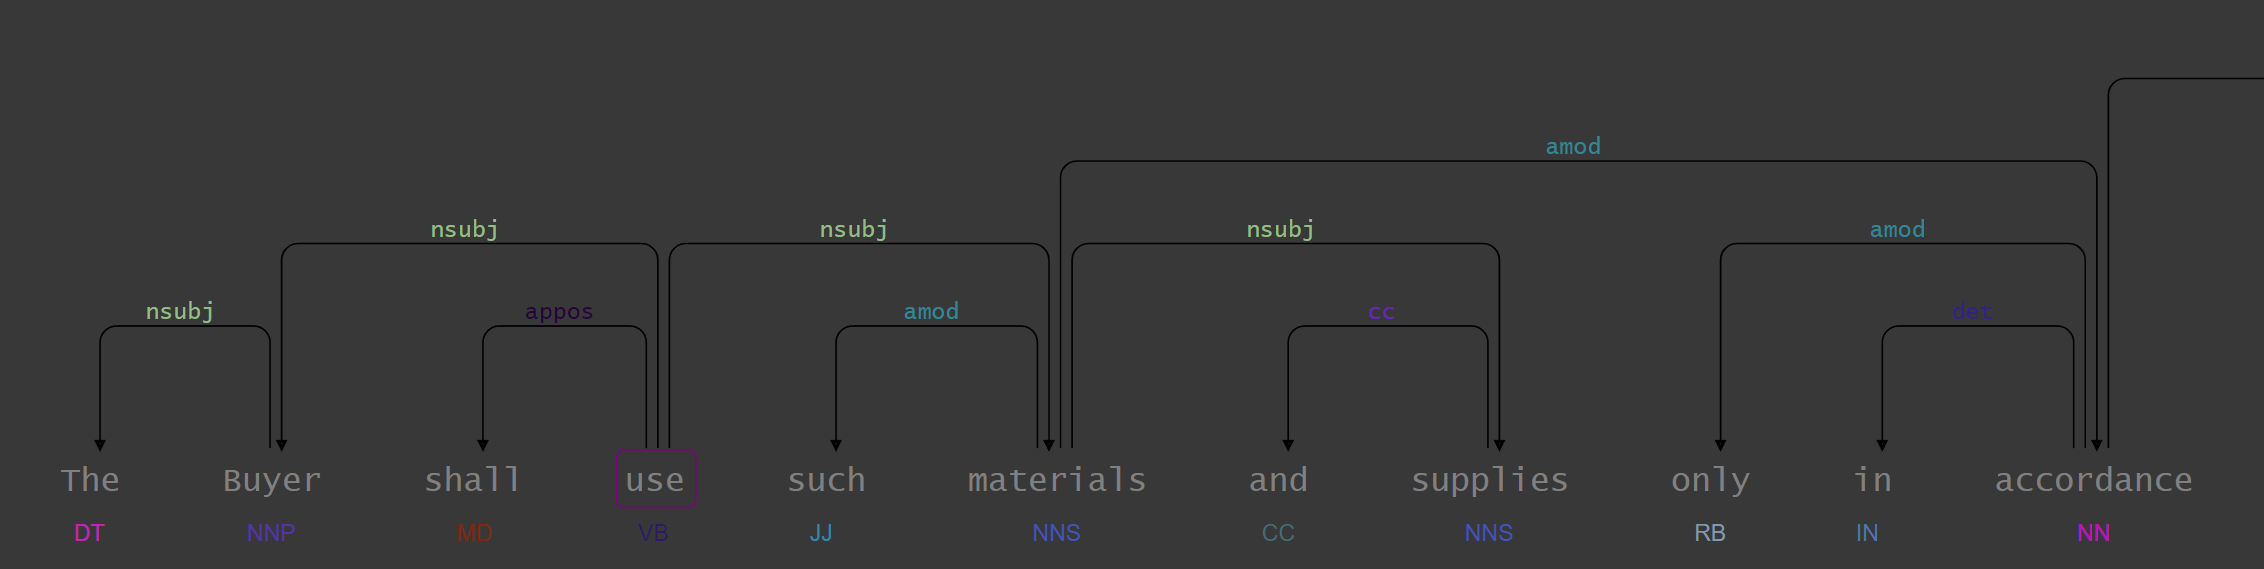

## Finding the `ACTION`
Let's get the root of the dependency trees (or the verb from pos)

In [ ]:
actions = result_df[(result_df['dependency_type']=='root') | (result_df['PoS']=='VB')]
actions

,chunk,begin,end,dependency,dependency_type,PoS
3,use,16,18,ROOT,root,VB


In [ ]:
action = actions['chunk'].tolist()[0]
action

'use'

Is there any verb modifier depending on `use`?

In [ ]:
action_modifier = result_df[(result_df['dependency']=='use') & (result_df['PoS']=='MD')]
action_modifier

,chunk,begin,end,dependency,dependency_type,PoS
2,shall,10,14,use,appos,MD


In [ ]:
action_modifier = action_modifier['chunk'].tolist()[0]
action_modifier

'shall'

In [ ]:
verb = " ".join([action_modifier, action])
verb

'shall use'

## Finding the `SUBJECT`


Let's get the the `nsubj` (noun chunks)

In [ ]:
nouns = result_df[result_df['dependency_type']=='nsubj']
nouns

,chunk,begin,end,dependency,dependency_type,PoS
0,The,0,2,Buyer,nsubj,DT
1,Buyer,4,8,use,nsubj,NNP
5,materials,25,33,use,nsubj,NNS
7,supplies,39,46,materials,nsubj,NNS
12,the,72,74,agreement,nsubj,DT


We have a mix of noun chunks. We need the SUBJECT of the verb, which is usually a proper noun `NNP`

In [ ]:
pnouns = nouns[nouns['PoS']=='NNP']
pnouns

,chunk,begin,end,dependency,dependency_type,PoS
1,Buyer,4,8,use,nsubj,NNP


In [ ]:
pnouns = pnouns['chunk'].tolist()[0]
pnouns

'Buyer'

We could here obtain also the modifiers, as the articles / determinants, but it's in most cases irrelevant in terms of meaning.

## Question:

In [ ]:
PARTICLE = "What" # We want the object, so this is the right W-word
SUBJECT = pnouns
ACTION = verb

QUESTION = " ".join([PARTICLE, SUBJECT, ACTION, "?"])
QUESTION

'What Buyer shall use ?'

# OPTION 2: Using NER
If we want to extract SUBJECTS and VERBS, we can also use `legner_obligations`.

In [ ]:
from johnsnowlabs import legal

document_assembler = nlp.DocumentAssembler()\
  .setInputCol("text")\
  .setOutputCol("document")

tokenizer = nlp.Tokenizer()\
  .setInputCols("document")\
  .setOutputCol("token")

ner = legal.BertForTokenClassification.pretrained("legner_obligations", "en", "legal/models")\
  .setInputCols("token", "document")\
  .setOutputCol("label")\
  .setCaseSensitive(True)

ner_converter = nlp.NerConverter()\
  .setInputCols(["document", "token", "label"])\
  .setOutputCol("ner_chunk")

df = spark.createDataFrame([[]])

pipeline = nlp.Pipeline(stages=[document_assembler, tokenizer, ner, ner_converter])

res = pipeline.fit(text_df).transform(text_df)

legner_obligations download started this may take some time.
[OK!]


In [ ]:
res.select(F.explode('ner_chunk')).filter("col['metadata'].entity in('OBLIGATION_SUBJECT', 'OBLIGATION_ACTION')").show(truncate=False)

+-----------------------------------------------------------------------------------------------------------------+
|col                                                                                                              |
+-----------------------------------------------------------------------------------------------------------------+
|{chunk, 4, 8, Buyer, {entity -> OBLIGATION_SUBJECT, sentence -> 0, chunk -> 0, confidence -> 0.86514723}, []}    |
|{chunk, 10, 18, shall use, {entity -> OBLIGATION_ACTION, sentence -> 0, chunk -> 1, confidence -> 0.9830627}, []}|
+-----------------------------------------------------------------------------------------------------------------+



In [ ]:
PARTICLE = "What" # We want the object, so this is the right W-word
SUBJECT = res.select(F.explode('ner_chunk')).filter("col['metadata'].entity in('OBLIGATION_SUBJECT')").select('col.result').collect()[0].result
ACTION = res.select(F.explode('ner_chunk')).filter("col['metadata'].entity in('OBLIGATION_ACTION')").select('col.result').collect()[0].result

QUESTION = " ".join([PARTICLE, SUBJECT, ACTION, "?"])
QUESTION

'What Buyer shall use ?'

### ... or automatically with `NerQuestionGenerator`
This component creates the questions for you automatically from NER extractions

Params:
- `setQuestionPronoun`: W-word of interrogative particle to add at the beginning (*What*, *When*, *To whom*, etc). `What...`
- `setEntities1`: Entity text to add to the question as first. `What shall use...`
- `setEntities2`: Entity text to add to the question as second. `What shall use the Buyer`
- `setQuestionMark`: for adding `?` at the end `What shall use the Buyer?`

In [ ]:
qagenerator = legal.NerQuestionGenerator()\
  .setInputCols(["ner_chunk"])\
  .setOutputCol("question")\
  .setQuestionMark(True)\
  .setQuestionPronoun("What")\
  .setEntities1(["OBLIGATION_SUBJECT"])\
  .setEntities2(["OBLIGATION_ACTION"])

In [ ]:
qagenerator.transform(res).show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|            document|               token|               label|           ner_chunk|            question|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|The Buyer shall u...|[{document, 0, 92...|[{token, 0, 2, Th...|[{named_entity, 0...|[{chunk, 4, 8, Bu...|[{document, 4, 18...|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+



In [ ]:
question_res = qagenerator.transform(res).select('question.result')
question_res.show(truncate=False)

+------------------------+
|result                  |
+------------------------+
|[What Buyer shall use ?]|
+------------------------+



In [ ]:
QUESTION = question_res.collect()[0].result
QUESTION

['What Buyer shall use ?']

### More examples of NER Question Generator

In [ ]:
texts = [
    """The Buyer shall use such materials and supplies only in accordance with the present agreement""",
    """The Provider will notify the Buyer about the release date""",
    """Amazon agrees to supply 1-year license without fees""",
    """The Supplier should ship the product in less than 1 month"""
]

In [ ]:
pdf = spark.createDataFrame(pd.DataFrame(texts, columns = ["text"]))
pdf

DataFrame[text: string]

In [ ]:
pipeline = nlp.Pipeline(stages=[document_assembler, tokenizer, ner, ner_converter, qagenerator])

res = pipeline.fit(pdf).transform(pdf)

In [ ]:
res.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|            document|               token|               label|           ner_chunk|            question|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|The Buyer shall u...|[{document, 0, 92...|[{token, 0, 2, Th...|[{named_entity, 0...|[{chunk, 4, 8, Bu...|[{document, 4, 18...|
|The Provider will...|[{document, 0, 56...|[{token, 0, 2, Th...|[{named_entity, 0...|[{chunk, 4, 11, P...|[{document, 4, 23...|
|Amazon agrees to ...|[{document, 0, 50...|[{token, 0, 5, Am...|[{named_entity, 0...|[{chunk, 0, 5, Am...|[{document, 0, 22...|
|The Supplier shou...|[{document, 0, 56...|[{token, 0, 2, Th...|[{named_entity, 0...|[{chunk, 4, 11, S...|[{document, 4, 23...|
+--------------------+--------------------+--------------------+--------------------+-------------------

In [ ]:
res.select('question.result').show(truncate=False)

+--------------------------------+
|result                          |
+--------------------------------+
|[What Buyer shall use ?]        |
|[What Provider will notify ?]   |
|[What Amazon agrees to supply ?]|
|[What Supplier should ship ?]   |
+--------------------------------+



# Other clauses
This approach works very well also with other clauses and phrases, as temporal ones. Let's try to ask for the deadline of a contract

Let's try to get now the Indirect Object. That is, the recipient of an action. For example, to whom a supplier should send a shipment.

In [ ]:
qagenerator = legal.NerQuestionGenerator()\
  .setInputCols(["ner_chunk"])\
  .setOutputCol("question")\
  .setQuestionMark(False)\
  .setQuestionPronoun("To whom")\
  .setEntities1(["OBLIGATION_ACTION"])\
  .setEntities2(["OBLIGATION_SUBJECT"])
  
pipeline = nlp.Pipeline(stages=[document_assembler, tokenizer, ner, ner_converter, qagenerator])

p_model = pipeline.fit(spark.createDataFrame(pd.DataFrame({'text': ['']})))

text = """The Provider shall send the shipment to the Buyer"""
res = p_model.transform(spark.createDataFrame([[text]]).toDF("text"))

res.select('question.result').show(truncate=False)

+------------------------------+
|result                        |
+------------------------------+
|[To whom shall send Provider ]|
+------------------------------+



In [ ]:
qagenerator = legal.NerQuestionGenerator()\
  .setInputCols(["ner_chunk"])\
  .setOutputCol("question")\
  .setQuestionMark(False)\
  .setQuestionPronoun("Before when")\
  .setEntities1(["OBLIGATION_ACTION"])\
  .setEntities2(["OBLIGATION_SUBJECT"])
  
pipeline = nlp.Pipeline(stages=[document_assembler, tokenizer, ner, ner_converter, qagenerator])

p_model = pipeline.fit(spark.createDataFrame(pd.DataFrame({'text': ['']})))

text = """The customer should sign the contract before May, 2023"""
res = p_model.transform(spark.createDataFrame([[text]]).toDF("text"))

In [ ]:
res.select('question.result').show(truncate=False)

+-----------------------------------+
|result                             |
+-----------------------------------+
|[Before when should sign customer ]|
+-----------------------------------+

